In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as Data
import torch.nn.utils.rnn as rnn_utils
import time
import pickle
from termcolor import colored

In [3]:
def genData(file,max_len):
    aa_dict={'A':1,'R':2,'N':3,'D':4,'C':5,'Q':6,'E':7,'G':8,'H':9,'I':10,
             'L':11,'K':12,'M':13,'F':14,'P':15,'O':16,'S':17,'U':18,'T':19,
             'W':20,'Y':21,'V':22,'X':23}
    with open(file, 'r') as inf:
        lines = inf.read().splitlines()
        
    long_pep_counter=0
    pep_codes=[]
    labels=[]
    for pep in lines:
        pep,label=pep.split(",")
        labels.append(int(label))
        if not len(pep) > max_len:
            current_pep=[]
            for aa in pep:
                current_pep.append(aa_dict[aa])
            pep_codes.append(torch.tensor(current_pep))
        else:
            long_pep_counter += 1
    print("length > {}:".format(max_len),long_pep_counter)
    data = rnn_utils.pad_sequence(pep_codes, batch_first=True)  # padding
    return data,torch.tensor(labels)

In [4]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for x, y in data_iter:
        x,y=x.to(device),y.to(device)
        outputs=net.trainModel(x)
        acc_sum += (outputs.argmax(dim=1) == y).float().sum().item()
        n += y.shape[0]
    return acc_sum / n

def to_log(log):
    with open("../compareModel/2021ACS_PepFormer/modelLog.log","a+") as f:
        f.write(log+'\n')

In [5]:
def collate(batch):
    seq1_ls=[]
    seq2_ls=[]
    label1_ls=[]
    label2_ls=[]
    label_ls=[]
    batch_size=len(batch)
    for i in range(int(batch_size/2)):
        seq1,label1=batch[i][0],batch[i][1]
        seq2,label2=batch[i+int(batch_size/2)][0],batch[i+int(batch_size/2)][1]
        label1_ls.append(label1.unsqueeze(0))
        label2_ls.append(label2.unsqueeze(0))
        label=(label1^label2)
        seq1_ls.append(seq1.unsqueeze(0))
        seq2_ls.append(seq2.unsqueeze(0))
        label_ls.append(label.unsqueeze(0))
    seq1=torch.cat(seq1_ls).to(device)
    seq2=torch.cat(seq2_ls).to(device)
    label=torch.cat(label_ls).to(device)
    label1=torch.cat(label1_ls).to(device)
    label2=torch.cat(label2_ls).to(device)
    return seq1,seq2,label,label1,label2
    

# New Train

# 1. Make Data X_train, y_train, X_test, y_test

In [6]:
df_detect_peptide_train = pd.read_csv('../data/df_detect_peptide_train_noptm_211018_includeDigest.csv')
df_detect_peptide_test = pd.read_csv('../data/df_detect_peptide_test_noptm_211018_includeDigest.csv')

tra, val = train_test_split(df_detect_peptide_train[['PEP', 'ID']], test_size=0.2, random_state=7)
tra.to_csv('../compareModel/2021ACS_PepFormer/detect_peptide_train_noptm_includeDigest.csv', header=False, index=False)
val.to_csv('../compareModel/2021ACS_PepFormer/detect_peptide_val_noptm_includeDigest.csv', header=False, index=False)
df_detect_peptide_test[['PEP', 'ID']].to_csv('../compareModel/2021ACS_PepFormer/detect_peptide_test_noptm_includeDigest.csv', header=False, index=False)

In [7]:
train_data,train_label=genData("../compareModel/2021ACS_PepFormer/detect_peptide_train_noptm_includeDigest.csv",81)
print(train_data.shape, train_label.shape)
train_dataset = Data.TensorDataset(train_data, train_label)

val_data,val_label=genData("../compareModel/2021ACS_PepFormer/detect_peptide_val_noptm_includeDigest.csv",81)
print(val_data.shape, val_label.shape)
val_dataset = Data.TensorDataset(val_data, val_label)

test_data,test_label=genData("../compareModel/2021ACS_PepFormer/detect_peptide_test_noptm_includeDigest.csv",81)
print(test_data.shape, test_label.shape)
test_dataset = Data.TensorDataset(test_data, test_label)

batch_size=256
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_iter_cont = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                                                  shuffle=True, collate_fn=collate)
val_iter = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

length > 81: 0
torch.Size([513513, 30]) torch.Size([513513])
length > 81: 0
torch.Size([128379, 30]) torch.Size([128379])
length > 81: 0
torch.Size([129204, 30]) torch.Size([129204])


# 2. train

In [8]:
class newModel(nn.Module):
    def __init__(self, vocab_size=24):
        super().__init__()
        self.hidden_dim = 25
        self.batch_size = 256
        self.emb_dim = 512
        
        self.embedding = nn.Embedding(vocab_size, self.emb_dim, padding_idx=0)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=1)
        
        self.gru = nn.GRU(self.emb_dim, self.hidden_dim, num_layers=2, 
                               bidirectional=True, dropout=0.2)
        
        
        self.block1=nn.Sequential(nn.Linear(1600,1024),
                                            nn.BatchNorm1d(1024),
                                            nn.LeakyReLU(),
                                            nn.Linear(1024,256),
                                 )

        self.block2=nn.Sequential(
                                               nn.BatchNorm1d(256),
                                               nn.LeakyReLU(),
                                               nn.Linear(256,128),
                                               nn.BatchNorm1d(128),
                                               nn.LeakyReLU(),
                                               nn.Linear(128,64),
                                               nn.BatchNorm1d(64),
                                               nn.LeakyReLU(),
                                               nn.Linear(64,2)
                                            )
        
    def forward(self, x):
        x=self.embedding(x)
        output=self.transformer_encoder(x).permute(1, 0, 2)
        output,hn=self.gru(output)
        output=output.permute(1,0,2)
        hn=hn.permute(1,0,2)
        output=output.reshape(output.shape[0],-1)
        hn=hn.reshape(output.shape[0],-1)
        output=torch.cat([output,hn],1)
        return self.block1(output)

    def trainModel(self, x):
        with torch.no_grad():
            output=self.forward(x)
        return self.block2(output)


class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        # euclidean_distance: [128]
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +     # calmp夹断用法
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))     
        
        return loss_contrastive
    
    


In [9]:
device = torch.device("cuda",0)

In [10]:
for num_model in range(1):  # just one train
    net=newModel().to(device)
    lr = 0.0001
    
    optimizer = torch.optim.Adam(net.parameters(), lr=lr,weight_decay=5e-4)
    criterion = ContrastiveLoss()
    criterion_model = nn.CrossEntropyLoss(reduction='sum')
    
    best_acc=0
    EPOCH=250
    for epoch in range(EPOCH):
        loss_ls=[]
        loss1_ls=[]
        loss2_3_ls=[]
        t0=time.time()
        net.train()
        for seq1,seq2,label,label1,label2 in train_iter_cont:
                output1=net(seq1)
                output2=net(seq2)
                output3=net.trainModel(seq1)
                output4=net.trainModel(seq2)
                
                loss1=criterion(output1, output2, label)
                loss2=criterion_model(output3,label1)
                loss3=criterion_model(output4,label2)
                loss=loss1+loss2+loss3
    #             print(loss)
                optimizer.zero_grad() 
                loss.backward()
                optimizer.step()
                loss_ls.append(loss.item())
                loss1_ls.append(loss1.item())
                loss2_3_ls.append((loss2+loss3).item())


        net.eval() 
        with torch.no_grad(): 
            train_acc=evaluate_accuracy(train_iter,net)
            test_acc=evaluate_accuracy(val_iter,net)
            
        results=f"epoch: {epoch+1}, loss: {np.mean(loss_ls):.5f}, loss1: {np.mean(loss1_ls):.5f}, loss2_3: {np.mean(loss2_3_ls):.5f}\n"
        results+=f'\ttrain_acc: {train_acc:.4f}, test_acc: {colored(test_acc,"red")}, time: {time.time()-t0:.2f}'
        print(results)
        if test_acc>best_acc:
            best_acc=test_acc
#             torch.save({"best_acc":best_acc,"model":net.state_dict()},f'compareModel/2021ACS_PepFormer/Model/{num_model}.pl')
            print(f"best_acc: {best_acc}")

epoch: 1, loss: 142.94299, loss1: 1.14200, loss2_3: 141.80099
	train_acc: 0.7658, test_acc: 0.7672672321797178, time: 207.12
best_acc: 0.7672672321797178
epoch: 2, loss: 120.70428, loss1: 0.91025, loss2_3: 119.79403
	train_acc: 0.7860, test_acc: 0.7863201925548571, time: 203.51
best_acc: 0.7863201925548571
epoch: 3, loss: 116.44320, loss1: 0.88006, loss2_3: 115.56314
	train_acc: 0.7998, test_acc: 0.8000529681645752, time: 202.92
best_acc: 0.8000529681645752
epoch: 4, loss: 113.85338, loss1: 0.85866, loss2_3: 112.99472
	train_acc: 0.8033, test_acc: 0.8043916839981617, time: 202.24
best_acc: 0.8043916839981617
epoch: 5, loss: 112.17126, loss1: 0.84583, loss2_3: 111.32543
	train_acc: 0.8076, test_acc: 0.8083019808535664, time: 160.09
best_acc: 0.8083019808535664
epoch: 6, loss: 111.32528, loss1: 0.83751, loss2_3: 110.48777
	train_acc: 0.8091, test_acc: 0.8090887138862275, time: 149.12
best_acc: 0.8090887138862275
epoch: 7, loss: 110.26829, loss1: 0.83087, loss2_3: 109.43742
	train_acc: 0.

epoch: 56, loss: 101.38520, loss1: 0.76120, loss2_3: 100.62400
	train_acc: 0.8234, test_acc: 0.8220581247711853, time: 206.00
epoch: 57, loss: 101.46735, loss1: 0.76151, loss2_3: 100.70584
	train_acc: 0.8280, test_acc: 0.825578949828243, time: 208.56
epoch: 58, loss: 101.22287, loss1: 0.76034, loss2_3: 100.46253
	train_acc: 0.8279, test_acc: 0.8259528427546561, time: 209.55
epoch: 59, loss: 101.26020, loss1: 0.76162, loss2_3: 100.49858
	train_acc: 0.8282, test_acc: 0.8265214715802429, time: 210.92
best_acc: 0.8265214715802429
epoch: 60, loss: 101.16820, loss1: 0.76065, loss2_3: 100.40755
	train_acc: 0.8281, test_acc: 0.8257658962914496, time: 211.49
epoch: 61, loss: 101.19486, loss1: 0.75872, loss2_3: 100.43613
	train_acc: 0.8275, test_acc: 0.8259840004985239, time: 210.73
epoch: 62, loss: 101.16990, loss1: 0.75780, loss2_3: 100.41210
	train_acc: 0.8280, test_acc: 0.8262566307573669, time: 211.56
epoch: 63, loss: 101.20215, loss1: 0.75872, loss2_3: 100.44343
	train_acc: 0.8275, test_ac

epoch: 116, loss: 100.04363, loss1: 0.75300, loss2_3: 99.29063
	train_acc: 0.8301, test_acc: 0.8267162074794164, time: 1015.16
epoch: 117, loss: 100.14688, loss1: 0.75413, loss2_3: 99.39275
	train_acc: 0.8305, test_acc: 0.827035574354061, time: 896.39
epoch: 118, loss: 100.13788, loss1: 0.75615, loss2_3: 99.38173
	train_acc: 0.8306, test_acc: 0.8281416742613668, time: 232.56
best_acc: 0.8281416742613668
epoch: 119, loss: 100.16233, loss1: 0.75399, loss2_3: 99.40834
	train_acc: 0.8305, test_acc: 0.8274717827682098, time: 247.89
epoch: 120, loss: 100.09071, loss1: 0.75461, loss2_3: 99.33610
	train_acc: 0.8303, test_acc: 0.8266850497355487, time: 244.19
epoch: 121, loss: 100.06966, loss1: 0.75346, loss2_3: 99.31620
	train_acc: 0.8306, test_acc: 0.8271446264575982, time: 244.14
epoch: 122, loss: 100.08975, loss1: 0.75405, loss2_3: 99.33570
	train_acc: 0.8306, test_acc: 0.8276431503594824, time: 243.98
epoch: 123, loss: 100.05184, loss1: 0.75328, loss2_3: 99.29857
	train_acc: 0.8305, test_a

epoch: 177, loss: 99.46758, loss1: 0.75282, loss2_3: 98.71477
	train_acc: 0.8301, test_acc: 0.8259061061388545, time: 122.48
epoch: 178, loss: 99.35583, loss1: 0.74926, loss2_3: 98.60657
	train_acc: 0.8317, test_acc: 0.8277444130270527, time: 122.56
epoch: 179, loss: 99.40483, loss1: 0.75149, loss2_3: 98.65334
	train_acc: 0.8320, test_acc: 0.8272380996892015, time: 126.22
epoch: 180, loss: 99.33420, loss1: 0.75227, loss2_3: 98.58193
	train_acc: 0.8315, test_acc: 0.82823514749297, time: 205.95
epoch: 181, loss: 99.40909, loss1: 0.75062, loss2_3: 98.65847
	train_acc: 0.8312, test_acc: 0.8273627306646726, time: 479.59
epoch: 182, loss: 99.36432, loss1: 0.74991, loss2_3: 98.61442
	train_acc: 0.8319, test_acc: 0.827565255999813, time: 504.88
epoch: 183, loss: 99.42398, loss1: 0.74998, loss2_3: 98.67401
	train_acc: 0.8322, test_acc: 0.8277599918989866, time: 646.07
epoch: 184, loss: 99.41297, loss1: 0.74942, loss2_3: 98.66355
	train_acc: 0.8320, test_acc: 0.8274484144603089, time: 684.28
epo

epoch: 239, loss: 99.00005, loss1: 0.74809, loss2_3: 98.25197
	train_acc: 0.8322, test_acc: 0.8274717827682098, time: 124.91
epoch: 240, loss: 99.05230, loss1: 0.75013, loss2_3: 98.30218
	train_acc: 0.8332, test_acc: 0.8278768334384907, time: 125.18
epoch: 241, loss: 99.09377, loss1: 0.74964, loss2_3: 98.34413
	train_acc: 0.8330, test_acc: 0.8281183059534659, time: 124.52
epoch: 242, loss: 98.99564, loss1: 0.75043, loss2_3: 98.24520
	train_acc: 0.8331, test_acc: 0.828367567904408, time: 124.67
epoch: 243, loss: 98.89686, loss1: 0.74841, loss2_3: 98.14845
	train_acc: 0.8337, test_acc: 0.8284610411360114, time: 124.43
best_acc: 0.8284610411360114
epoch: 244, loss: 98.89383, loss1: 0.74801, loss2_3: 98.14582
	train_acc: 0.8331, test_acc: 0.8275263088199784, time: 124.13
epoch: 245, loss: 99.01166, loss1: 0.74833, loss2_3: 98.26333
	train_acc: 0.8319, test_acc: 0.8275185193840114, time: 122.06
epoch: 246, loss: 98.96129, loss1: 0.74777, loss2_3: 98.21353
	train_acc: 0.8333, test_acc: 0.828

# 3. test

In [11]:
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [12]:
def pred(data_iter, net):
    y_pred = []
    for x, y in data_iter:
        x,y=x.to(device),y.to(device)
        outputs=net.trainModel(x)
        for _ in outputs.argmax(dim=1):
            y_pred.append(int(_))
    return y_pred

In [13]:
def pred_prob(data_iter, net):
    y_pred = []
    for x, y in data_iter:
        x,y=x.to(device),y.to(device)
        outputs=net.trainModel(x)
        for _ in outputs:
            y_pred.append(list(map(float, _)))
    return y_pred

In [14]:
test_acc = evaluate_accuracy(test_iter,net)
print('Test Accuracy: {}'.format(test_acc))

# prediction
y_pred = pred(test_iter, net)
print(classification_report(test_label, y_pred))

Test Accuracy: 0.8302451936472555
              precision    recall  f1-score   support

           0       0.87      0.77      0.82     64602
           1       0.80      0.89      0.84     64602

    accuracy                           0.83    129204
   macro avg       0.83      0.83      0.83    129204
weighted avg       0.83      0.83      0.83    129204



rf auc : 0.9126659943439498


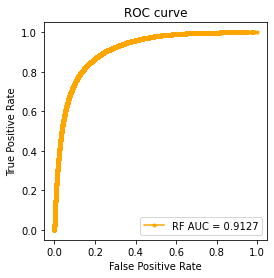

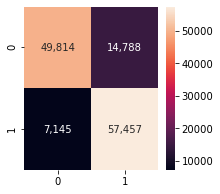

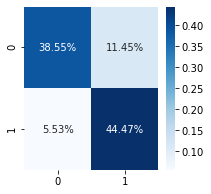

In [15]:
# AUC
probs = np.array(pred_prob(test_iter, net))[:, 1]
rf_auc = roc_auc_score(test_label, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model81
rf_fpr, rf_tpr, _ = roc_curve(test_label, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

cf_matrix = confusion_matrix(test_label, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()